#  Données spatiales: découverte de geopandas



<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_tutorial.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_tutorial.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_tutorial.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?onyxia.friendlyName=«python-datascientist»&resources.requests.memory=«4Gi»&init.personnalInit=«https://raw.githubusercontent.com/linogaliana/python-datascientist/master/init_onyxia.sh»)
[![Binder](https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=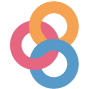)](https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath=notebooks/course/manipulation/03_geopandas_tutorial.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/manipulation/03_geopandas_tutorial.ipynb)

Dans ce tutoriel, nous allons utiliser:

<!----
* [Réseau de pistes cyclables de la ville de Paris](https://opendata.paris.fr/explore/dataset/reseau-cyclable/table/?disjunctive.typologie_simple&disjunctive.bidirectionnel&disjunctive.statut&disjunctive.sens_velo&disjunctive.voie&disjunctive.arrdt&disjunctive.bois&disjunctive.position&disjunctive.circulation&disjunctive.piste&disjunctive.couloir_bus&disjunctive.type_continuite&disjunctive.reseau&basemap=jawg.streets&location=12,48.85943,2.3493)
------>

* [Localisations des stations velib](https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr)
* [Carte des limites administratives françaises](https://www.data.gouv.fr/fr/datasets/r/07b7c9a2-d1e2-4da6-9f20-01a7b72d4b12)
* [Arrondissements parisiens](https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr)

La représentation des données, notamment la cartographie, est présentée plus
amplement dans la partie [visualiser](#visualiser). Quelques méthodes
pour faire rapidement des cartes seront présentées ici mais
ce n'est pas l'objet de celle-ci.

Ce tutoriel s'inspire beaucoup d'un autre tutoriel que j'ai fait pour
`R` disponible
[dans la documentation `utilitr`](https://www.book.utilitr.org/spatdata.html).
Il peut servir de pendant à celui-ci pour l'utilisateur de `R`. 

Quelques installations préalables sont nécessaires : 


In [ ]:
!pip install pandas fiona shapely pyproj rtree # à faire obligatoirement en premier pour utiliser rtree ou pygeos pour les jointures spatiales
!pip install contextily
!pip install geopandas

Pour être en mesure d'exécuter ce tutoriel, les imports suivants
seront utiles.


In [ ]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

# Données spatiales: quelle différence avec des données traditionnelles ?

**Le terme "données spatiales" désigne les données qui portent sur les caractéristiques géographiques des objets (localisation, contours, liens)**. Les caractéristiques géographiques des objets sont décrites à l'aide d'un **système de coordonnées**
qui permettent une représentation dans un espace euclidien ($(x,y)$).
Le passage de l'espace réel (la Terre, qui est une sphère) à l'espace plan
se fait grâce à un **système de projection**. Voici quelques exemples
de données spatiales:

* Une table décrivant des bâtiments, avec les coordonnées géographiques de chaque bâtiment;
* Le découpage communal du territoire, avec le contour du territoire de chaque commune;
* Les routes terrestres, avec les coordonnées décrivant leur parcours.

Les données spatiales rassemblent classiquement deux types de données :

1. des **données géographiques** (ou géométries): objets géométriques tels que des points, des vecteurs, des polygones, ou des maillages (*raster*). Exemple: la forme de chaque chaque commune, les coordonnées d'un bâtiment;
2. des **données attributaires** (ou attributs): des mesures et des caractéristiques associés aux objets géométriques. Exemple: la population de chaque commune, le nombre de fenêtres et le nombre d'étages d'un bâtiment.

**Les données spatiales sont fréquemment traitées à l'aide d'un système d'information géographique (SIG)**, c'est-à-dire un système d'information capable de stocker, d'organiser et de présenter des données alphanumériques spatialement référencées par des coordonnées dans un système de référence (CRS). `R` dispose de fonctionnalités lui permettant de réaliser les mêmes tâches qu'un SIG (traitement de données spatiales, représentations cartographiques).

**Les systèmes de projection font l'objet de standards internationaux et sont souvent désignés par des codes dits codes EPSG**. Ce [site](https://epsg.io/) est un bon aide-mémoire. Les plus fréquents, pour les utilisateurs français, sont les suivants (plus d'infos [ici](https://geodesie.ign.fr/contenu/fichiers/documentation/SRCfrance.pdf)):

* `2154`: système de projection Lambert 93. Il s'agit du système de projection officiel: la plupart des données diffusées par l'administration pour la métropole sont disponibles dans ce système de projection. 
* `27572`: Lambert II étendu. Il s'agit de l'ancien système de projection officiel. Les données spatiales anciennes peuvent être dans ce format.
* `4326`: WGS 84 ou système de pseudo-Mercator. Attention, ce n'est en réalité pas un système de projection mais un système de coordonnées (longitude / latitude) qui permet simplement un repérage angulaire sur l'ellipsoïde. Il est utilisé pour les données GPS.

## De `pandas` à `geopandas`

Le *package* `geopandas` est une boîte à outils conçue pour faciliter la manipulation de données spatiales. **La grande force de `geopandas` est qu'il permet de manipuler des données spatiales comme s'il s'agissait de données traditionnelles**, car il repose sur le standard ISO 19125 [*simple feature access*](https://en.wikipedia.org/wiki/Simple_Features) défini conjointement par l'*Open Geospatial Consortium (OGC)* et l'*International Organization for Standardization (ISO)*. 

Par rapport à un DataFrame standard, un objet `geopandas` comporte
une colonne supplémentaire: `geometry`. Elle stocke les coordonnées des
objets géographiques (ou ensemble de coordonnées s'agissant de contours). Un objet `geopandas` hérite des propriétés d'un 
DataFrame pandas mais propose des méthodes adaptées au traitement des données spatiales. 

Ainsi, grâce à  `geopandas`, on pourra effectuer des manipulations sur les attributs des données comme avec `pandas` mais on pourra également faire des manipulations sur la dimension spatiale des données. En particulier,

* Calculer des distances et des surfaces;
* Agréger rapidement des zonages (regrouper les communes en département par exemple);
* Trouver dans quelle commune se trouve un bâtiment à partir de ses coordonnées géographiques;
* Recalculer des coordonnées dans un autre système de projection.
* Faire une carte, rapidement et simplement

Les manipulations de données sur un objet geopandas sont nettement plus lentes que sur un DataFrame traditionnel (car python doit gérer les informations géographiques pendant la manipulation des données). Lorsque vous manipulez des données de grandes dimensions, il peut être préférable d’effectuer les opérations sur les données avant de joindre une géométrie à celles-ci.

Par rapport à un logiciel spécialisé comme `QGIS`, `python` permettra 
d'automatiser le traitement et la représentation des données. D'ailleurs,
`QGIS` utilise lui-même `python`...

# Importer des données spatiales

Les données spatiales sont plus riches que les données traditionnelles car elles
incluent, habituellement, des éléments supplémentaires pour placer dans
un espace cartésien les objets. Cette dimension supplémentaire peut être simple
(un point comporte deux informations supplémentaire: $x$ et $y$) ou
assez complexe (polygones, lignes avec direction, etc.)

Les formats les plus communs de données spatiales sont les suivants:

* _shapefile_ (`.shp`): format (**propriétaire**) le plus commun de données géographiques.
La table de données (attributs) est stockée dans un fichier séparé des
données spatiales. En faisant `geopandas.read_file("monfichier.shp")`, le
package fait lui-même le lien entre les observations et leur représentation spatiale ;
* _geojson_ (`.json`) : ce format, non préconisé par l'OGC est largement utilisé pour le développement web comme dans la librairie `Leaflet`. La dimension spatiale est stockée dans le même fichier que les attributs. Ces fichiers sont généralement beaucoup plus légers que les *shapefiles* mais possèdent des limites s'agissant de gros jeux de données. 
* _geopackage_ (`.gpkg`) : ce (relativement) nouveau format **libre** en un seul fichier également (lui recommandé par l'OGC) vise progressivement à se substituer au shapefile. Il est par exemple le format par défaut dans QGIS. 

Cette [page](https://si.ecrins-parcnational.com/blog/2020-02-geojson-shapefile-geopackage.html) compare plus en détail ces trois types de formats de données géographiques. 

L'aide de [geopandas](https://geopandas.org/io.html) propose des bouts de code en fonction des différentes situations dans lesquelles on se trouve.

### Exemple: récupérer les découpages territoriaux

L'un des fonds de carte les plus fréquents qu'on utilise est celui des
limites administratives. Elles peuvent être trouvées sur le
[site de l'IGN](https://geoservices.ign.fr/adminexpress#telechargementCog) ou récupérées sur
[data.gouv](https://www.data.gouv.fr/fr/datasets/decoupage-administratif-communal-francais-issu-d-openstreetmap/) (construites par `openstreetmap`).
Il est également possible d'utiliser l'une des [API de l'IGN](https://api.gouv.fr/les-api/api_carto_cadastre)
mais ces dernières ne sont pas encore très documentées pour des utilisateurs
de `Python`.

Nous choisirons la deuxième option (import depuis datagouv)
car les premières données sont
compressés au format `.7z`, ce qui n'est pas pratique à dézipper avec
`python` (format propriétaire).

L'inconvénient est que les arrondissements
parisiens ne sont pas présents dans le fichier proposé sur `data.gouv`. Il
faut donc utiliser une source complémentaire, issue de l'*opendata* de la 
Mairie de Paris.

Les données des limites administratives demandent donc un peu de travail pour être
importées car elles sont zippées (mais c'est un bon exercice !). Le code suivant, dont les 
détails apparaîtront plus clairs après la lecture de la partie
*[webscraping](webscraping)* permet de :

1. Télécharger les données avec `requests` dans un dossier temporaire
2. Les dézipper avec le module `zipfile`

La fonction suivante automatise un peu le processus :


In [ ]:
import requests
import tempfile
import zipfile

url = 'https://www.data.gouv.fr/fr/datasets/r/07b7c9a2-d1e2-4da6-9f20-01a7b72d4b12'
temporary_location = tempfile.gettempdir()

def download_unzip(url, dirname = tempfile.gettempdir(), destname = "borders"):
  myfile = requests.get(url)
  open("{}/{}.zip".format(dirname, destname), 'wb').write(myfile.content)
  with zipfile.ZipFile("{}/{}.zip".format(dirname, destname), 'r') as zip_ref:
      zip_ref.extractall(dirname + '/' + destname)

In [ ]:
download_unzip(url)
communes = gpd.read_file(temporary_location + "/borders/communes-20190101.json")
communes.head()

```
##    insee  ...                                           geometry
## 0  97223  ...  POLYGON ((-60.93595 14.58812, -60.93218 14.585...
## 1  97233  ...  POLYGON ((-61.12165 14.71928, -61.11852 14.716...
## 2  97208  ...  POLYGON ((-61.13355 14.74657, -61.13066 14.748...
## 3  97224  ...  POLYGON ((-61.08459 14.72510, -61.08430 14.722...
## 4  97212  ...  POLYGON ((-61.08459 14.72510, -61.08061 14.725...
## 
## [5 rows x 5 columns]
```

On reconnaît la structure d'un DataFrame pandas. A cette structure s'ajoute 
une colonne `geometry` qui enregistre la position des limites des polygones de chaque
observation. 

Comme vu précédemment, le système de projection est un élément important. Il permet à `python`
d'interpréter les valeurs des points (deux dimensions) en position sur 
la terre, qui n'est pas un espace plan. Ici, les données ne sont pas projetées puisqu'elles sont dans le 
système WSG84 (epsg: 4326) ce qui permet de facilement ajouter
un fonds de carte `openstreetmap` ou `stamen` pour rendre une représentation
graphique plus esthétique. En toute rigueur, pour faire une carte statique d'un pays en particulier, il faudrait reprojeter les données dans un système de projection adapté à la zone géographique étudiée (par exemple le Lambert-93 pour la France métropolitaine).

On peut ainsi représenter Paris pour se donner une idée de la nature
du shapefile utilisé :


In [ ]:
paris = communes[communes.insee.str.startswith("75")]
ax = paris.plot(figsize=(10, 10), alpha=0.5, edgecolor='blue')
ctx.add_basemap(ax, crs = paris.crs.to_string())
ax.set_axis_off()
ax

On voit ainsi que les données pour Paris ne comportent pas d'arrondissement, 
ce qui est limitant pour une analyse focalisée sur Paris. On va donc les
récupérer sur le site d'open data de la ville de Paris et les substituer 
à Paris


In [ ]:
arrondissements = gpd.read_file("https://opendata.paris.fr/explore/dataset/arrondissements/download/?format=geojson&timezone=Europe/Berlin&lang=fr")
arrondissements = arrondissements.rename(columns = {"c_arinsee": "insee"})
arrondissements['insee'] = arrondissements['insee'].astype(str)
communes = communes[~communes.insee.str.startswith("75")].append(arrondissements)

En refaisant la carte ci-dessus, on obtient bien, cette fois, le résultat
espéré


In [ ]:
paris = communes[communes.insee.str.startswith("75")]
ax = paris.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, crs = paris.crs.to_string())
ax.set_axis_off()
ax

# Opérations sur les attributs et les géométries

## Import des données velib

Souvent, le découpage communal ne sert qu'en fond de cartes, pour donner des
repères. En complément de celui-ci, on peut désirer exploiter
un autre jeu de données. On va partir des données de localisation des
stations velib, 
disponibles [sur le site d'open data de la ville de Paris](https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/table/) et 
requêtables directement par l'url
<https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr>


In [ ]:
velib_data = 'https://opendata.paris.fr/explore/dataset/velib-emplacement-des-stations/download/?format=geojson&timezone=Europe/Berlin&lang=fr'
stations = gpd.read_file(velib_data)

In [ ]:
communes['dep'] = communes.insee.str[:2]

On peut se rassurer en affichant les données sur la carte des communes d'Île-de-France.

Découvrez ci-dessous par étape les différentes lignes de commandes permettant d'afficher une carte complète,
étape par étape:

:one: Afficher le nuage de point de 200 stations vélibs prises au hasard


In [ ]:
ax = stations.sample(200).plot(figsize = (10,10), color = 'red', alpha = 0.4, zorder=2)
#communes[communes['dep'].isin(['75','92','93','94'])].plot(ax = ax, zorder=1, edgecolor = "black", facecolor="none",
#                                                           color = None)
#ctx.add_basemap(ax, crs = stations.crs.to_string(), source = ctx.providers.Stamen.Watercolor)
# ax.set_axis_off()
ax

:two: Y ajouter en dessous les contours des communes


In [ ]:
ax = stations.sample(200).plot(figsize = (10,10), color = 'red', alpha = 0.4, zorder=2)
communes[communes['dep'].isin(['75','92','93','94'])].plot(ax = ax, zorder=1, edgecolor = "black", facecolor="none",
                                                           color = None)
#ctx.add_basemap(ax, crs = stations.crs.to_string(), source = ctx.providers.Stamen.Watercolor)
# ax.set_axis_off()
ax

```
## <AxesSubplot:>
```




:three:  Y ajouter un fond de carte de type *open street map* grâce au package
`contextily`


In [ ]:
ax = stations.sample(200).plot(figsize = (10,10), color = 'red', alpha = 0.4, zorder=2)
communes[communes['dep'].isin(['75','92','93','94'])].plot(ax = ax, zorder=1, edgecolor = "black", facecolor="none",
                                                           color = None)
ctx.add_basemap(ax, crs = stations.crs.to_string(), source = ctx.providers.Stamen.Watercolor)
# ax.set_axis_off()
ax

```
## <AxesSubplot:>
```



:four:  Retirer les axes des coordonnées


In [ ]:
ax = stations.sample(200).plot(figsize = (10,10), color = 'red', alpha = 0.4, zorder=2)
communes[communes['dep'].isin(['75','92','93','94'])].plot(ax = ax, zorder=1, edgecolor = "black", facecolor="none",
                                                           color = None)
ctx.add_basemap(ax, crs = stations.crs.to_string(), source = ctx.providers.Stamen.Watercolor)
ax.set_axis_off()
ax

```
## <AxesSubplot:>
```

*In fine*, on obtient la carte ci-dessous:




## Opérations sur les attributs

Toutes les opérations possibles sur un objet `pandas` le sont également
sur un objet `geopandas`. Pour manipuler les données, et non la géométrie,
on parlera d'opérations sur les attributs. 

Par exemple, si on désire 
connaître quelques statistiques sur la taille des stations:


In [ ]:
stations.describe()

```
##           capacity
## count  1432.000000
## mean     31.142458
## std      12.145603
## min       0.000000
## 25%      23.000000
## 50%      29.000000
## 75%      37.000000
## max      74.000000
```

Pour connaître les plus grands départements:


In [ ]:
communes.groupby('dep').sum().sort_values('surf_ha', ascending = False)

```
##        surf_ha       n_sq_co      perimetre       surface       n_sq_ar   c_ar
## dep                                                                           
## 97   8936393.0  0.000000e+00       0.000000  0.000000e+00  0.000000e+00    0.0
## 33   1008481.0  0.000000e+00       0.000000  0.000000e+00  0.000000e+00    0.0
## 40    935359.0  0.000000e+00       0.000000  0.000000e+00  0.000000e+00    0.0
## 24    922025.0  0.000000e+00       0.000000  0.000000e+00  0.000000e+00    0.0
## 21    879892.0  0.000000e+00       0.000000  0.000000e+00  0.000000e+00    0.0
## ..         ...           ...            ...           ...           ...    ...
## 90     61048.0  0.000000e+00       0.000000  0.000000e+00  0.000000e+00    0.0
## 94     24467.0  0.000000e+00       0.000000  0.000000e+00  0.000000e+00    0.0
## 93     23674.0  0.000000e+00       0.000000  0.000000e+00  0.000000e+00    0.0
## 92     17546.0  0.000000e+00       0.000000  0.000000e+00  0.000000e+00    0.0
## 75         0.0  1.500003e+10  190443.799631  1.053728e+08  1.500000e+10  210.0
## 
## [97 rows x 6 columns]
```

ou les plus grandes communes de France métropolitaine :


In [ ]:
communes[communes.dep != "97"].sort_values('surf_ha', ascending = False)

```
##        insee                       nom  ...  c_ar  dep
## 29861  13004                     Arles  ...   NaN   13
## 29386  73290                 Val-Cenis  ...   NaN   73
## 29632  13096  Saintes-Maries-de-la-Mer  ...   NaN   13
## 32467  49092         Chemillé-en-Anjou  ...   NaN   49
## 28877  49228           Noyant-Villages  ...   NaN   49
## ...      ...                       ...  ...   ...  ...
## 15     75118                       NaN  ...  18.0   75
## 16     75113                       NaN  ...  13.0   75
## 17     75117                       NaN  ...  17.0   75
## 18     75106                       NaN  ...   6.0   75
## 19     75109                       NaN  ...   9.0   75
## 
## [34870 rows x 13 columns]
```


Lors des étapes d'agrégation, `groupby` ne conserve pas les géométries. Autrement
dit, si on effectue, par exemple, une somme en fonction d'une variable de groupe avec
le combo `groupby(...).sum(...)` , on perd
la dimension géographique. 

Il est néanmoins possible d'aggréger à la fois les géométries et les 
attribus avec la méthode `dissolve`: 



In [ ]:
plt.figure()
communes[communes.dep != "97"].dissolve(by='dep', aggfunc='sum').plot(column = "surf_ha")

## Opérations sur les géométries

Les données sont en système de coordonnées WGS 84 ou pseudo-Mercator (epsg: `4326`) et ne sont pas projetées. C'est un format approprié lorsqu'il s'agit d'utiliser un fonds
de carte openstreetmap, stamen, google maps, etc.

Mais ce n'est pas un
format sur lequel on désire faire des calculs car les distances sont faussées sans utiliser de projection. D'ailleurs, geopandas refusera certaines opérations
sur des données dont le crs est `4326`. On reprojete ainsi les données 
dans la projection officielle pour la métropole, le Lambert 93
(epsg: 2154).



In [ ]:
communes = communes.to_crs(2154)
stations = stations.to_crs(2154)

Outre la représentation graphique simplifiée,
sur laquelle nous reviendrons ultérieurement, l'intérêt principal d'utiliser
`geopandas` est l'existence de méthodes efficaces pour
manipuler la dimension spatiale. Un certain nombre proviennent du 
package
[shapely](https://shapely.readthedocs.io/en/latest/manual.html#general-attributes-and-methods). 

Par exemple, on peut recalculer la taille d'une commune ou d'arrondissement
avec la méthode `area` (et diviser par $10^6$ pour avoir des $km^2$ au lieu
des $m^2$):


In [ ]:
communes['superficie'] = communes.area.div(10**6)
communes

Une méthode qu'on utilise régulièrement est `centroid` qui, comme son nom l'indique,
recherche le centroïde de chaque polygone et transforme ainsi des données
surfaciques en données ponctuelles. Par exemple, pour
représenter approximativement les centres des villages de la
Haute-Garonne (31), on
fera


In [ ]:
departement = communes[communes.dep == "31"].copy()
departement['geometry'] = departement['geometry'].centroid


```
## <string>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.
```

In [ ]:
ax = departement.plot(figsize = (10,10), color = 'red', alpha = 0.4, zorder=2)
communes[communes['dep'] == "31"].plot(ax = ax, zorder=1, edgecolor = "black", facecolor="none",
                                                           color = None)
ctx.add_basemap(ax, crs = stations.crs.to_string(), source = ctx.providers.Stamen.Toner)
ax.set_axis_off()
ax

```
## <AxesSubplot:>
```





# Gérer le système de projection

Précédemment, nous avons appliqué une méthode `to_crs` pour reprojeter
les données dans un système de projection différent de celui du fichier
d'origine:

In [ ]:
communes = communes.to_crs(2154)
stations = stations.to_crs(2154)

Le système de projection est fondamental pour que la dimension
spatiale soit bien interprétée par `python`. Un mauvais système de représentation
fausse l'appréciation visuelle mais peut aussi entraîner des erreurs dans
les calculs sur la dimension spatiale.
Ce [post](https://www.earthdatascience.org/courses/earth-analytics/spatial-data-r/geographic-vs-projected-coordinate-reference-systems-UTM/) propose de riches éléments sur le
sujet, notamment l'image suivante qui montre bien le principe d'une projection:

![Les différents types de projection](https://www.earthdatascience.org/images/courses/earth-analytics/spatial-data/spatial-projection-transformations-crs.png)

La [documentation officielle de geopandas](https://geopandas.org/projections.html) est également très bien
faite sur le sujet. Elle fournit notamment l'avertissement suivant qu'il est
bon d'avoir en tête:

> Be aware that most of the time you don’t have to set a projection. Data loaded from a reputable source (using the geopandas.read_file() command) should always include projection information. You can see an objects current CRS through the GeoSeries.crs attribute.
> 
> From time to time, however, you may get data that does not include a projection. In this situation, you have to set the CRS so geopandas knows how to interpret the coordinates.

![](https://imgs.xkcd.com/comics/bad_map_projection_south_america.png)
*Image empruntée à <https://blog.chrislansdown.com/2020/01/17/a-great-map-projection-joke/>*

Pour déterminer le système de projection d'une base de données, on peut vérifier l'attribut `crs`:


In [ ]:
communes.crs

```
## <Geographic 2D CRS: EPSG:4326>
## Name: WGS 84
## Axis Info [ellipsoidal]:
## - Lat[north]: Geodetic latitude (degree)
## - Lon[east]: Geodetic longitude (degree)
## Area of Use:
## - name: World.
## - bounds: (-180.0, -90.0, 180.0, 90.0)
## Datum: World Geodetic System 1984
## - Ellipsoid: WGS 84
## - Prime Meridian: Greenwich
```

Les deux principales méthodes pour définir le système de projection utilisé sont:

* **`df.set_crs`**: cette commande sert à préciser quel est le système de projection utilisé, c'est-à-dire comment les coordonnées *(x,y)* sont reliées à la surface terrestre. **Cette commande ne doit pas être utilisée pour transformer le système de coordonnées, seulement pour le définir**. 
* **`df.to_crs`**: **cette commande sert à projeter les points d'une géométrie dans une autre, c'est-à-dire à recalculer les coordonnées selon un autre système de projection.** 

Dans le cas particulier de production de carte avec un fond `openstreetmaps` ou une carte dynamique `leaflet`, il est nécessaire de dé-projeter les données (par exemple à partir du Lambert-93) pour atterrir dans le système non-projeté WGS 84 (code EPSG 4326). Ce site [dédié aux projections géographiques](https://epsg.io/) peut-être utile pour retrouver le système de projection d'un fichier où il n'est pas indiqué. 

La définition du système de projection se fait de la manière suivante (:warning: avant de le faire, se souvenir de l'avertissement !):


In [ ]:
communes = communes.set_crs(2154)

Alors que la reprojection (projection Albers: 5070) s'obtient de la manière suivante:


In [ ]:
plt.figure()
communes[communes.dep != "97"].dissolve(by='dep', aggfunc='sum').to_crs(5070).plot()

On le voit, cela modifie totalement la représentation de l'objet dans l'espace.
Clairement, cette projection n'est pas adaptée aux longitudes et latitudes françaises. C'est normal, il s'agit d'une projection adaptée au continent 
nord-américain (et encore, pas dans son ensemble !).


In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world[world.continent == "North America"].to_crs(5070).plot(alpha = 0.2, edgecolor = "k")

# Joindre des données

## Joindre données sur des attributs

Ce type de jointure se fait entre un objet géographique et un
deuxième objet, géographique ou non. A l'exception de la question 
des géométries, il n'y a pas de différence par rapport à `pandas`. 

La seule différence avec `pandas` est dans la dimension géographique.
Si on désire conserver la dimension géographique, il faut faire 
attention à faire:

~~~~python
geopandas_object.merge(pandas_object)
~~~~

Si on utilise deux objets géographiques mais ne désire conserver qu'une seule
dimension géographique[^1], on fera

~~~~python
geopandas_object1.merge(geopandas_object2)
~~~~

Seule la géométrie de l'objet de gauche
sera conservée, même si on fait un *right join*. 

[^1]: Il est techniquement possible d'avoir un DataFrame comportant plusieurs
géographies. Par exemple une géométrie polygone et une géométrie point
(le centroid). C'est néanmoins souvent compliqué à gérer et donc peu
recommandable.


### Prolongation possible : joindre données sur dimension géographique

**Conseils**
Les jointures spatiales peuvent être très gourmandes en ressources (car il peut être nécessaire de croiser toutes les géométries de `x` avec toutes les géométries de `y`). Voici deux conseils qui peuvent vous aider:

- Il est préférable de tester les jointures géographiques sur un petit échantillon de données, pour estimer le temps et les ressources nécessaires à la réalisation de la jointure.
- Il est parfois possible d'écrire une fonction qui réduit la taille du problème. Exemple: vous voulez déterminer dans quelle commune se situe un logement dont vous connaissez les coordonnées et le département; vous pouvez écrire une fonction qui réalise pour chaque département une jointure spatiale entre les logements situés dans ce département et les communes de ce département, puis empiler les 101 tables de sorties.

